In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

plt.style.use("seaborn-v0_8")  

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DATA_PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
FIGURES_DIR = os.path.join(PROJECT_ROOT, "results", "figures")

os.makedirs(FIGURES_DIR, exist_ok=True)

print("Python executable:", sys.executable)
print("Processed data dir:", DATA_PROCESSED_DIR)
print("Figures dir:", FIGURES_DIR)


Python executable: c:\DAT494\bayesian_regime_switching\.venv\Scripts\python.exe
Processed data dir: c:\DAT494\bayesian_regime_switching\data\processed
Figures dir: c:\DAT494\bayesian_regime_switching\results\figures


In [2]:
TICKER = "^GSPC"
PROCESSED_FILE = os.path.join(
    DATA_PROCESSED_DIR,
    f"{TICKER.replace('^', '')}_returns_processed.csv"
)

data = pd.read_csv(PROCESSED_FILE, parse_dates=['Date'], index_col='Date')
data.head()


,AdjClose,SimpleReturn,LogReturn,RollingVol_21,CumReturn
Date,,,,,
2000-01-04,1399.420044,-0.038345,-0.039099,NaN,0.961655
2000-01-05,1402.109985,0.001922,0.001920,NaN,0.963504
2000-01-06,1403.449951,0.000956,0.000955,NaN,0.964425
2000-01-07,1441.469971,0.027090,0.026730,NaN,0.990551
2000-01-10,1457.599976,0.011190,0.011128,NaN,1.001635


In [3]:
print("Shape:", data.shape)
print("Date range:", data.index.min(), "to", data.index.max())
print("\nColumns:", data.columns.tolist())
print("\nMissing values:\n", data.isna().sum())

# Assertions: fail early if something is off
assert data.index.is_monotonic_increasing, "Index must be sorted by date"
assert data['LogReturn'].isna().sum() == 0, "No NaNs allowed in LogReturn"
assert data.shape[0] > 1000, "Too few data points, check your date range"

data.describe()


Shape: (6516, 5)
Date range: 2000-01-04 00:00:00 to 2025-11-28 00:00:00

Columns: ['AdjClose', 'SimpleReturn', 'LogReturn', 'RollingVol_21', 'CumReturn']

Missing values:
 AdjClose          0
SimpleReturn      0
LogReturn         0
RollingVol_21    20
CumReturn         0
dtype: int64


,AdjClose,SimpleReturn,LogReturn,RollingVol_21,CumReturn
count,6516.000000,6516.000000,6516.000000,6496.000000,6516.000000
mean,2253.599122,0.000312,0.000238,0.010323,1.548631
std,1432.023405,0.012215,0.012232,0.006692,0.984060
min,676.530029,-0.119841,-0.127652,0.002185,0.464899
25%,1209.807495,-0.004739,-0.004750,0.006190,0.831357
50%,1522.515015,0.000639,0.000639,0.008612,1.046244
75%,2879.965088,0.005896,0.005878,0.012458,1.979058
max,6890.890137,0.115800,0.109572,0.061454,4.735291


## Time Series Visuals

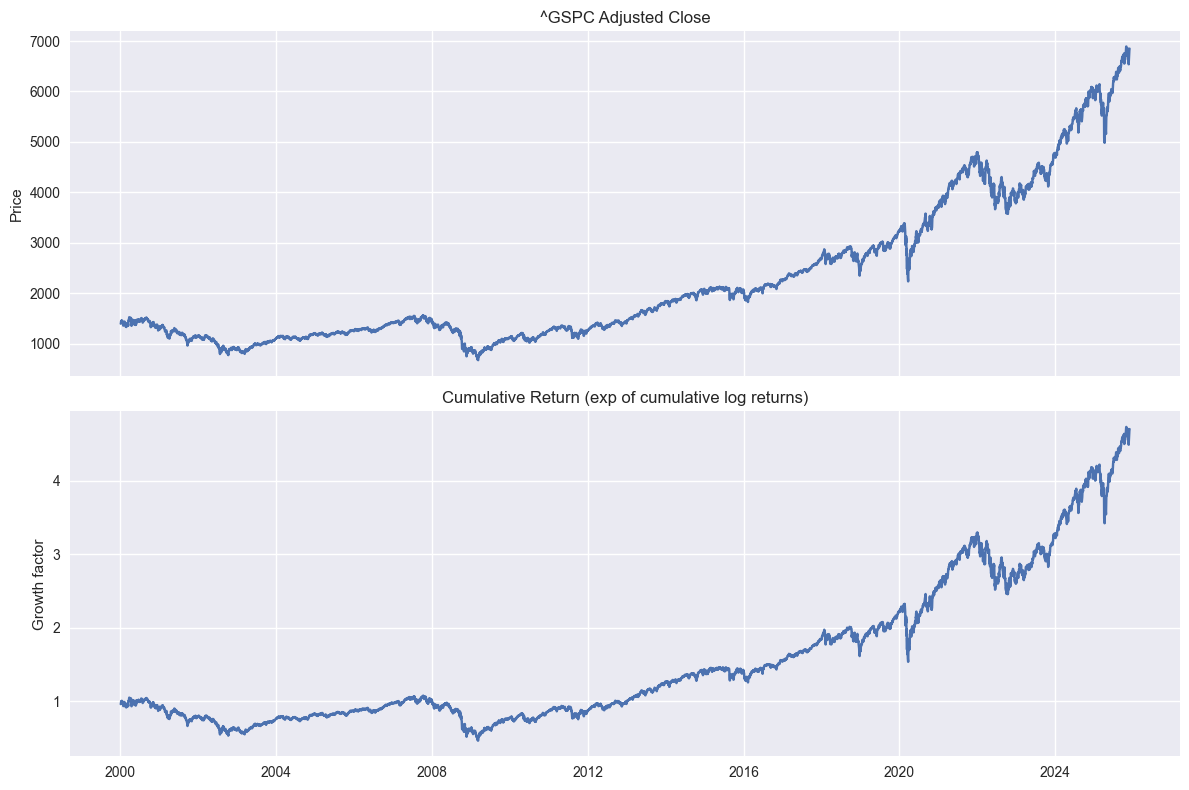

Saved figure: c:\DAT494\bayesian_regime_switching\results\figures\spx_price_cumreturn.png


In [4]:
# Price and Cumulative Return Plot

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(data.index, data['AdjClose'])
axes[0].set_title(f"{TICKER} Adjusted Close")
axes[0].set_ylabel("Price")

axes[1].plot(data.index, data['CumReturn'])
axes[1].set_title("Cumulative Return (exp of cumulative log returns)")
axes[1].set_ylabel("Growth factor")

plt.tight_layout()
plt.show()

fig_path = os.path.join(FIGURES_DIR, "spx_price_cumreturn.png")
fig.savefig(fig_path, dpi=200)
print("Saved figure:", fig_path)


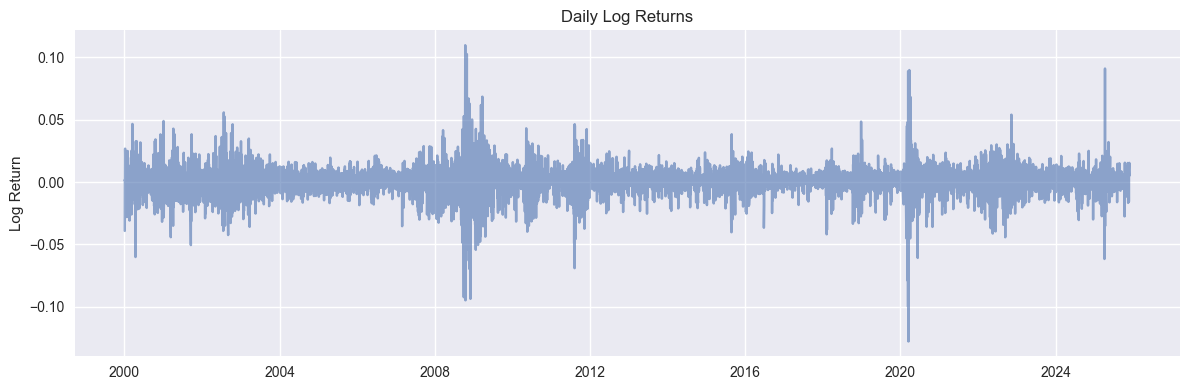

Saved figure: c:\DAT494\bayesian_regime_switching\results\figures\spx_logreturns_timeseries.png


In [5]:
# Log Returns

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(data.index, data['LogReturn'], alpha=0.6)
ax.set_title("Daily Log Returns")
ax.set_ylabel("Log Return")
plt.tight_layout()
plt.show()

fig_path = os.path.join(FIGURES_DIR, "spx_logreturns_timeseries.png")
fig.savefig(fig_path, dpi=200)
print("Saved figure:", fig_path)


## Distributional Shape 

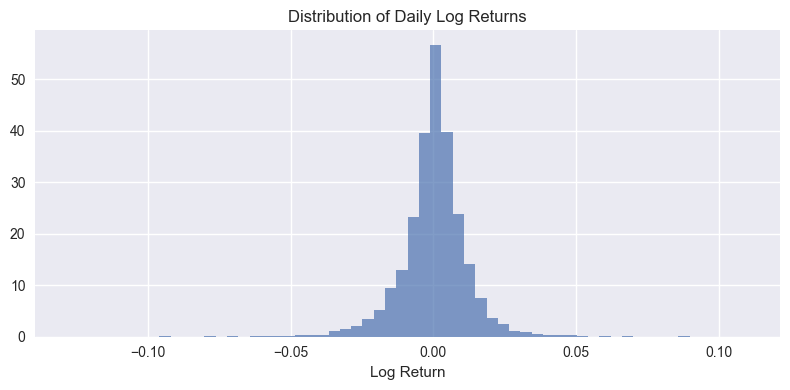

In [6]:
# Histogram and KDE

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(data['LogReturn'], bins=60, density=True, alpha=0.7)
ax.set_title("Distribution of Daily Log Returns")
ax.set_xlabel("Log Return")
plt.tight_layout()
plt.show()


In [7]:
#check 

lr = data['LogReturn']

stats_summary = {
    "mean": lr.mean(),
    "std": lr.std(),
    "skew": lr.skew(),
    "kurtosis (excess)": lr.kurtosis()
}
stats_summary


{'mean': np.float64(0.00023771619123853105),
 'std': np.float64(0.012231541754906004),
 'skew': np.float64(-0.3485189252688752),
 'kurtosis (excess)': np.float64(10.605698804378314)}

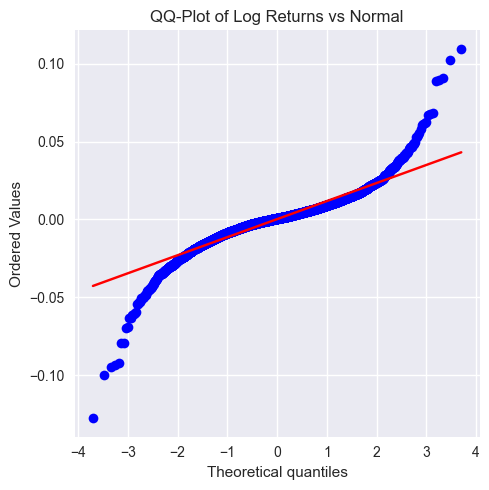

Saved figure: c:\DAT494\bayesian_regime_switching\results\figures\spx_logreturns_qqplot.png


In [8]:
# QQ plot vs. Normal

fig, ax = plt.subplots(figsize=(5, 5))
stats.probplot(lr, dist="norm", plot=ax)
ax.set_title("QQ-Plot of Log Returns vs Normal")
plt.tight_layout()
plt.show()

fig_path = os.path.join(FIGURES_DIR, "spx_logreturns_qqplot.png")
fig.savefig(fig_path, dpi=200)
print("Saved figure:", fig_path)


## Volatility Clustering & Regime Feel

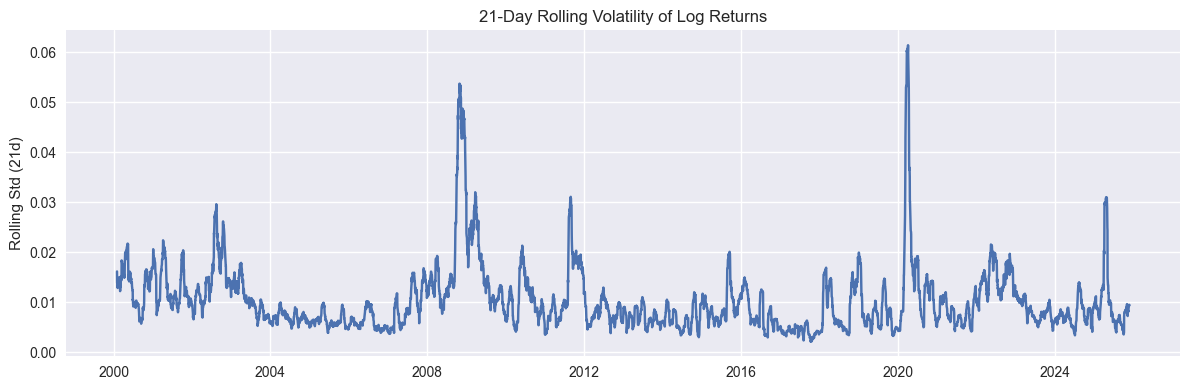

Saved figure: c:\DAT494\bayesian_regime_switching\results\figures\spx_rolling_vol_21.png


In [9]:
# Rolling Volatility

if 'RollingVol_21' not in data.columns:
    data['RollingVol_21'] = data['LogReturn'].rolling(21).std()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(data.index, data['RollingVol_21'])
ax.set_title("21-Day Rolling Volatility of Log Returns")
ax.set_ylabel("Rolling Std (21d)")
plt.tight_layout()
plt.show()

fig_path = os.path.join(FIGURES_DIR, "spx_rolling_vol_21.png")
fig.savefig(fig_path, dpi=200)
print("Saved figure:", fig_path)


## Simple Regime Proxy (Pre-HMM Intuition)

In [10]:
#Define High vs. Low Volatility Regimes

vol = data['RollingVol_21'].dropna()

# High Volatility: above 75th percentile
high_vol_threshold = vol.quantile(0.75)
low_vol_threshold = vol.quantile(0.25)

high_vol_threshold, low_vol_threshold

(np.float64(0.0124584846508467), np.float64(0.0061896946227867))

In [11]:
def classify_vol_regime(v, low_thr, high_thr):
    if np.isnan(v):
        return np.nan
    if v <= low_thr:
        return "low_vol"
    elif v >= high_thr:
        return "high_vol"
    else:
        return "mid_vol"

data['VolRegime'] = data['RollingVol_21'].apply(
    lambda x: classify_vol_regime(x, low_vol_threshold, high_vol_threshold)
)

data['VolRegime'].value_counts(dropna=False)


VolRegime
mid_vol     3248
high_vol    1624
low_vol     1624
NaN           20
Name: count, dtype: int64

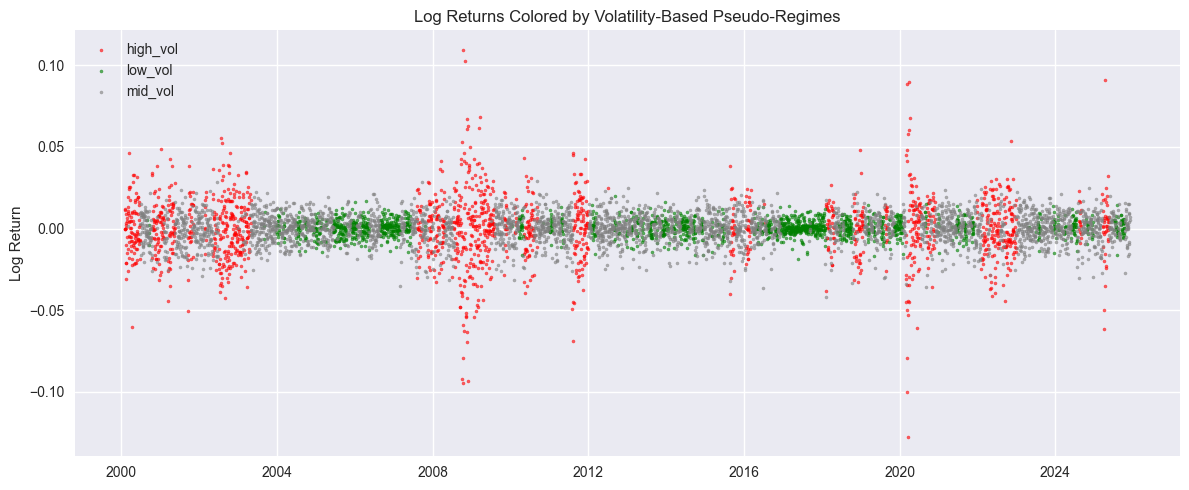

Saved figure: c:\DAT494\bayesian_regime_switching\results\figures\spx_logreturns_by_pseudo_regime.png


In [12]:
#Visualize Regimes on Returns

fig, ax = plt.subplots(figsize=(12, 5))

colors = {
    "low_vol": "green",
    "mid_vol": "gray",
    "high_vol": "red"
}

for regime, group in data.groupby('VolRegime'):
    ax.scatter(group.index, group['LogReturn'], s=5,
               label=regime, alpha=0.6, c=colors.get(regime, "blue"))

ax.set_title("Log Returns Colored by Volatility-Based Pseudo-Regimes")
ax.set_ylabel("Log Return")
ax.legend()
plt.tight_layout()
plt.show()

fig_path = os.path.join(FIGURES_DIR, "spx_logreturns_by_pseudo_regime.png")
fig.savefig(fig_path, dpi=200)
print("Saved figure:", fig_path)


## Empirical Stats by Pseudo-Regime (For Priors)

In [13]:
#Grouped Stats

regime_stats = (
    data.dropna(subset=['VolRegime'])
        .groupby('VolRegime')['LogReturn']
        .agg(['mean', 'std', 'count'])
        .sort_values('std')
)

regime_stats


,mean,std,count
VolRegime,,,
low_vol,0.000567,0.005190,1624
mid_vol,0.000126,0.009001,3248
high_vol,0.000156,0.020202,1624


## Summary of Exploratory Analysis

- The distribution of daily log returns exhibits **heavy tails** and **negative skewness**, confirming that extreme market moves occur more often than a normal distribution would predict.  
- The time series of returns shows clear **volatility clustering**, where periods of calm are followed by periods of turbulence. This strongly motivates the need for **state-dependent variance** in a regime-switching model.
- The 21-day rolling volatility analysis reveals **persistent high-volatility and low-volatility periods**, which visually correspond to “bear” and “bull” market regimes.
- Empirical statistics derived from pseudo-regime classification indicate:
  - **Low-vol regime:** small positive mean returns and low variance  
  - **High-vol regime:** near-zero or negative mean returns and substantially higher variance
- These empirical observations will directly inform the choice of **prior distributions** for the Bayesian Hidden Markov Model (HMM) in the next phase of the project.